In [2]:
import pandas as pd
import tqdm
import datetime
df = pd.read_csv("./daily/stock_2024-12-23.csv")
cdf = pd.read_csv("stock_today.csv")
df = pd.concat([df,cdf])

def delta_dates():
    today = datetime.datetime.now()
    offsets = [-14,-7,-3]
    hdates = []
    for off in offsets:
        offset = datetime.timedelta(days=off)
        hdate = (today + offset).strftime('%Y-%m-%d')
        hdates.append(hdate)
    hdates.append(today.strftime('%Y-%m-%d'))
    return list(zip(hdates[:-1],hdates[1:]))

def make_record(g,date):
    g = g[g["date"]<date]
    g = g.sort_values(by="date",ascending=False)[:10]
    today = datetime.datetime.now()
    offset = datetime.timedelta(days=-10)
    lastday=(today + offset).strftime('%Y-%m-%d')
    if g[g["date"]>lastday].shape[0]>0 and g.shape[0]>=10:
        # print(g.shape)
        name = g.iloc[0]["name"]
        last_1day, last_3_days, last_7days = g.iloc[0], g.iloc[1:3], g.iloc[5:]
        last_7day_volume = last_7days.volume.mean()
        last_3day_volume = last_3_days.volume.mean()/last_7day_volume
        last_1day_volume = last_1day.volume/last_7day_volume
        last_3day_change = g.iloc[1].close/g.iloc[3].close
        last_1day_change = g.iloc[0].close/g.iloc[1].close
        last_1day_cc = (last_1day.close/last_1day.open-1)*100
        last_1day_cm = ((last_1day.high-last_1day.close)/g.iloc[1].close)*100
        last_1day_cl = ((last_1day.close-last_1day.low)/g.iloc[1].close)*100
        last_1day_amp = ((last_1day.high-last_1day.low)/g.iloc[1].close)*100
        # print(g.iloc[0].volume,last_7day_volume,g.iloc[0])
        last_3day_change = (last_3day_change-1)*100
        last_1day_change = (last_1day_change-1)*100
        return {"name":name,"last_3day_volume":last_3day_volume,"last_1day_volume":last_1day_volume,
                        "last_3day_change":last_3day_change,"last_1day_change":last_1day_change,"last_1day_cm":last_1day_cm,
                        "last_1day_cc":last_1day_cc,"last_1day_cl":last_1day_cl,"last_1day_amp":last_1day_amp}

def make_data(df,cdate,flag=True):
    records = []
    for k,g in tqdm.tqdm(df.groupby("code"),desc=f"processing date[{cdate}]"):
        record = make_record(g,cdate)
        if record:
            record["date"]=cdate
            record["code"]=k
            if flag:
                cg,pg = g[g.date==cdate],g[g.date<cdate].sort_values("date",ascending=False)
                if cg.shape[0]>0 and pg.shape[0]>0:
                    change = cg.iloc[0].close/pg.iloc[0].close
                    change = (change-1)*100
                    record["change"]=change
                    records.append(record)
            else:
                records.append(record)     
                
    return pd.DataFrame(records)

lst = []
hdts, cdt =("2024-12-19","2024-12-20","2024-12-23","2024-12-24"),"2024-12-25"
for dt in hdts:
    tdf = make_data(df,dt)
    lst.append(tdf)
padf = pd.concat(lst)
cadf = make_data(df,cdt,False)
padf.head()   
       

processing date[2024-12-25]: 100%|████████████████████████████████████████████████████████████████████████████████████| 4674/4674 [00:17<00:00, 261.02it/s]


,name,last_3day_volume,last_1day_volume,last_3day_change,last_1day_change,last_1day_cm,last_1day_cc,last_1day_cl,last_1day_amp,date,code,change
0,浦发银行,0.899448,0.949907,-1.345756,0.104932,1.469045,-0.209205,0.314795,1.783841,2024-12-19,sh600000,-0.104822
1,白云机场,0.894684,0.565059,-0.909091,-0.101937,0.611621,-0.406504,0.203874,0.815494,2024-12-19,sh600004,-0.408163
2,东风股份,1.059173,0.861627,-4.014599,1.520913,2.788340,1.136364,2.661597,5.449937,2024-12-19,sh600006,-3.370787
3,中国国贸,2.024033,1.020505,4.780196,0.040733,0.977597,-0.365112,1.059063,2.036660,2024-12-19,sh600007,-2.280130
4,首创环保,0.993621,0.798642,0.298507,0.595238,0.892857,0.296736,0.595238,1.488095,2024-12-19,sh600008,-1.775148


<Axes: >

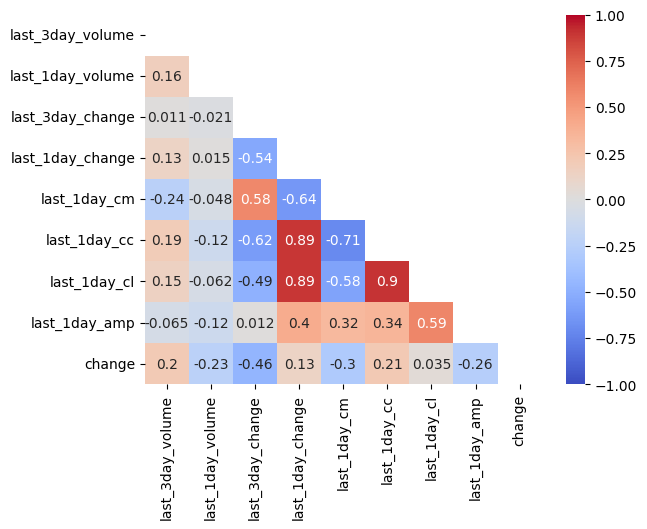

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# pdf = adf[(adf.last_3day_volume>4)&(adf.last_1day_volume>4)][:50].copy()
pdf = padf[(padf.last_3day_volume<1.5)&(padf.last_1day_volume>3)][:50].copy()
pdf.drop(columns=["code","name","date"],inplace=True)
upp_mat = np.triu(pdf.corr())
sns.heatmap(pdf.corr(), vmin=-1, vmax=+1, annot=True, cmap="coolwarm", mask=upp_mat)
# def ascore(v):
#     frac = v.last_1day_volume/v.last_3day_volume
#     return frac*(v.last_1day_cl-v.last_1day_cm)

# adf["score"]=adf.apply(ascore,axis=1)
# adf.sort_values(by="score",ascending=False)[:50]


In [3]:
from sklearn.model_selection import train_test_split
pdf =padf.dropna().copy()
pdf = pdf[pdf["last_1day_amp"]>0.1]
y = pdf.pop("change")
pdf.drop(columns=["code","name","date"],inplace=True)
X = pdf
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,roc_auc_score,mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
# Create a pipeline with preprocessor and classifier
model = Pipeline(steps=[ ('regressor', GradientBoostingRegressor())])
param_distributions = {'regressor__n_estimators': [50, 100,],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [4, 5],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [2, 4],
    'regressor__subsample': [0.7, 0.8, ]}
# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, 
    param_distributions=param_distributions, 
    n_iter=30,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    verbose=2, 
    scoring = 'r2',
    random_state=42,
    n_jobs=-1  )
# Fit the RandomizedSearchCV model
random_search.fit(X_train, y_train)
best_gb = random_search.best_estimator_
test_prediction_gb = random_search.predict(X_test)
print(f"MSE is: {mean_squared_error(y_test, test_prediction_gb)}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
MSE is: 11.254111553281248


In [5]:
pdf = cadf.copy()
pdf = pdf[pdf["last_1day_amp"]>0.1]
ctrain = pdf.drop(columns=["code","name","date"])
pdf["pred"] = random_search.predict(ctrain)
pdf.sort_values(by="pred",ascending=False)[:15]

,name,last_3day_volume,last_1day_volume,last_3day_change,last_1day_change,last_1day_cm,last_1day_cc,last_1day_cl,last_1day_amp,date,code,pred
1955,中百集团,2.091740,4.237761,-15.811966,5.456853,3.426396,6.538462,15.482234,18.908629,2024-12-25,sz000759,5.081549
433,克劳斯,3.560466,1.706149,20.946626,9.991674,0.000000,0.075758,0.166528,0.166528,2024-12-25,sh600579,3.804457
1296,鼎信通讯,5.377971,7.662752,21.092757,9.968520,0.000000,0.000000,8.079748,8.079748,2024-12-25,sh603421,3.124160
52,中船科技,3.063723,5.976405,9.071274,-1.980198,3.960396,-1.980198,0.198020,4.158416,2024-12-25,sh600072,2.076549
2766,盛通股份,0.571839,0.691346,-7.445443,9.986130,0.000000,0.000000,0.554785,0.554785,2024-12-25,sz002599,2.041898
2419,奥 特 迅,1.249096,0.721404,-13.871951,10.000000,0.000000,10.488889,10.442478,10.442478,2024-12-25,sz002227,1.917610
3936,中富电路,1.958986,1.447078,-7.932489,3.391384,2.016499,3.076454,5.377330,7.393828,2024-12-25,sz300814,1.686732
2141,立新能源,2.398554,6.786057,11.904762,9.973404,0.000000,4.683544,6.515957,6.515957,2024-12-25,sz001258,1.661958
3161,三和管桩,0.597181,0.416704,-13.272011,10.000000,0.000000,7.237814,7.727273,7.727273,2024-12-25,sz003037,1.542107
471,天宸股份,0.738557,0.612119,-6.936416,-1.708075,2.795031,-1.093750,2.484472,5.279503,2024-12-25,sh600620,1.519211


[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__min_samples_leaf=2, regressor__min_samples_split=2, regressor__n_estimators=50, regressor__subsample=0.7; total time=   4.5s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=4, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=50, regressor__subsample=0.8; total time=   4.8s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=4, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=50, regressor__subsample=0.8; total time=   4.2s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=4, regressor__min_samples_leaf=4, regressor__min_samples_split=2, regressor__n_estimators=50, regressor__subsample=0.8; total time=   3.8s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=100, regressor__subsample=0.7; total time=   7.8s
[CV]

In [ ]:
pdf[pdf.name=="中材节能"]

In [220]:
import pandas as pd
import tqdm
today = datetime.datetime.now()
tdt = today.strftime('%Y-%m-%d')
df = pd.read_csv("stock_hist.csv")
cdf = pd.read_csv("stock_today.csv")
df = pd.concat([df,cdf])
df.to_csv(f"stock_{tdt}.csv",index=False)

,code,name,last_3day_volume,last_1day_volume,last_3day_change,last_1day_change,last_1day_cm,last_1day_cc,last_1day_cl,last_1day_amp,date,pred
1097,sh600000,中材节能,6.789314,9.104236,7.669617,3.835616,3.972603,7.213579,12.876712,16.849315,2024-12-24,-4.645817
